In [0]:
#Run once per session
import os
!pip install -q feather-format kornia pyarrow wandb nbdev fastprogress fastai2 fastcore --upgrade 
!pip install Pillow==6.2.1 --upgrade
os._exit(00)

# Object Detection

Finding the localized area in which an object presides from two points, the bottom left and top right

![](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/06/maxresdefault.jpg)

# The Data

Before we begin training, let's focus on how to build the `DataLoader`. We'll want to use the `Pascal_VOC` dataset today

In [0]:
from fastai2.vision.all import *

In [0]:
path = untar_data(URLs.PASCAL_2007)

Now how do we get our labels? `fastai2` has a `get_annotations` function that we can use to grab the image and their bounding box. The one-line documentation states:
"Open a COCO style json in `fname` and returns the list of filenames (with mabye `prefix`) and labelled bounding boxes."

In [3]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/test.json')]

We'll want to read out of the `train.json`

In [0]:
imgs, lbl_bbox = get_annotations(path/'train.json')

In [5]:
imgs[0]

'000012.jpg'

In [6]:
lbl_bbox[0]

([[155, 96, 351, 270]], ['car'])

Next, we want to be able to quickly look up a corresponding image to it's label. We'll use a dictionary

In [0]:
img2bbox = dict(zip(imgs, lbl_bbox))

Let's check the first item

In [8]:
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'000012.jpg': ([[155, 96, 351, 270]], ['car'])}

Great! Now let's build our `DataBlock`. We'll have two outputs, the bounding box itself and a label, with one input. For our `y`'s, we'll define some `getters`. The first of which will be `noop`, as we don't care about our initial image, and then we'll grab our label and bbox coordinates (we'll also define our `get_items`)

In [0]:
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]

For our transforms, we'll use some of the ones we defined earlier

In [0]:
item_tfms = [Resize(224)]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

Why do we need a custom `get_images`? Because we want our **images** that came back to us, not the entire folder

In [0]:
def get_train_imgs(noop):  return imgs

We'll now make our `DataBlock`. We want to adjust `n_inp` as we expect two outputs

In [0]:
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs, 
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [0]:
dls = pascal.dataloaders(path/'train')

In [0]:
dls.c = 20

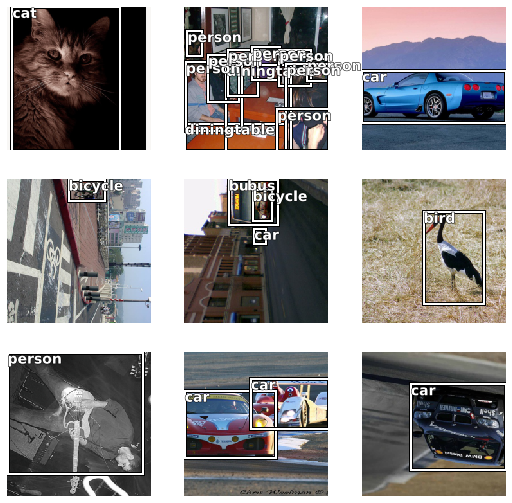

In [15]:
dls.show_batch()

# The Model

The architecture we are going to use is called `RetinaNet`. I've exported this all myself for you guys to use quickly, if you want to explore what's going on in the code I'd recommend the Object Detection lesson [here](https://www.youtube.com/watch?v=Z0ssNAbe81M&t=4496s)

Let's clone my repo and work out of it

In [16]:
!git clone https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0.git
%cd "Practical-Deep-Learning-for-Coders-2.0/Computer Vision"

/content/Practical-Deep-Learning-for-Coders-2.0/Computer Vision


In [0]:
from imports import *

We're still going to use transfer learning here by creating an `encoder` (body) of our model and a head

In [0]:
encoder = create_body(resnet34, pretrained=True)

Now that we have our encoder, we can call the `RetinaNet` architecture. We'll pass in the encoder, the number of classes, and what we want our final bias to be on the last convolutional layer (how we initialize our model). Jeremy has his example at -4 so let's use this

In [19]:
get_c(dls)

20

In [0]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

Another big difference is the head of our model. Instead of our linear layers with pooling layers:

In [21]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=124, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

We have one with a smoother, a classifer, and a `box_regressor` (to get our points)

In [22]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [23]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [24]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## Loss Function
Now we can move onto our loss function. For RetinaNet to work, we need to define what the aspect ratio's and scales of our image should be. The paper used [1,2**(1/3), 2**(2/3)], but they also used an image size of 600 pixels, so even the largest feature map (box) gave anchors that covered less than the image. But for us it would go over. As such we will use -1/3 and -2/3 instead. We will need these for inference later!

In [0]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

Let's make our loss function, which is `RetinaNetFocalLoss`

In [0]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

Now let's make our `Learner`!

We want to freeze our `encoder` and keep everything else unfrozen to start

In [0]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [0]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [0]:
learn.freeze()

In [30]:
learn.summary()

RetinaNet (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
__________________________________________________

We can see it was split and frozen by looking at the summary!

Now let's train!

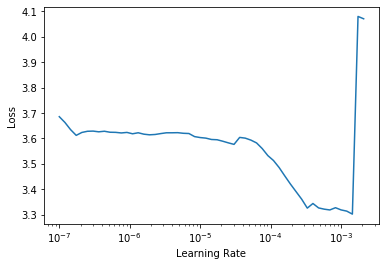

In [32]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
